# Inspect prediction results from a Random Forest classifier

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sn
import pickle
import matplotlib.pyplot as plt
from plotnine import *
from sklearn.metrics import classification_report, confusion_matrix
import read_settings

Set input and output directories

In [2]:
# Read settings
global_settings = read_settings.check_global()
instrument = global_settings['input_data']['instrument']
# Directory for input data
data_dir = os.path.join('data', instrument)
# Directory for training outputs
output_dir = os.path.join('output', '_'.join(['rf', instrument]))

## Input data

In [3]:
df_comp = pd.read_csv(os.path.join(output_dir, 'df_comp.csv')).set_index('classif_id')

<Figure size 432x288 with 0 Axes>

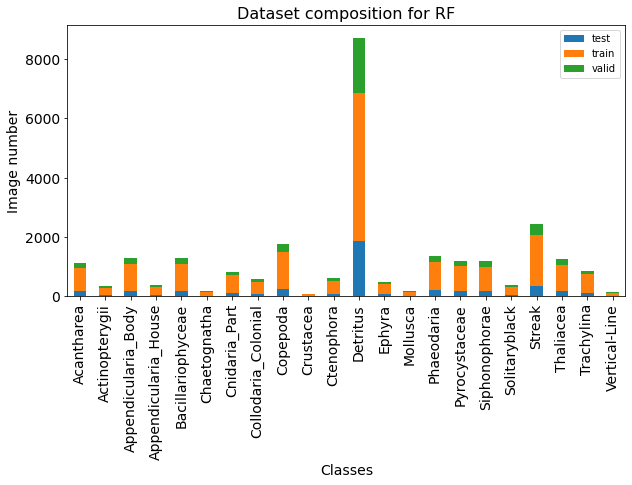

In [4]:
plt.figure()
df_comp.plot.bar(stacked=True, figsize=(10,5), fontsize = 14)
plt.xlabel("Classes", fontsize = 14)
plt.ylabel("Image number", fontsize = 14)
plt.legend(loc="best")
plt.title("Dataset composition for RF", fontsize = 16)
plt.show()

## Training

Read training file

In [5]:
with open(os.path.join(output_dir, 'train_results.pickle'),'rb') as results_file:
    train_results = pickle.load(results_file)
    train_results = pd.DataFrame(train_results)

Plot gridsearch results

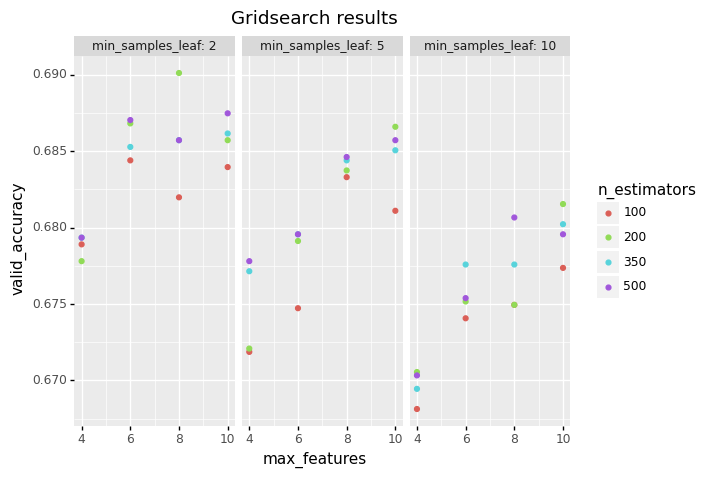

<ggplot: (-9223363304642045468)>

In [6]:
(ggplot(train_results) +
  geom_point(aes(x='max_features', y='valid_accuracy', colour='factor(n_estimators)'))+
  facet_wrap('~min_samples_leaf', labeller = 'label_both') +
  labs(colour='n_estimators', title = 'Gridsearch results'))

## Testing

### Confusion matrix

Read test file

In [7]:
with open(os.path.join(output_dir, 'test_results.pickle'),'rb') as results_file:
    test_results = pickle.load(results_file)
    
    true_classes = test_results.get('true_classes')
    predicted_classes = test_results.get('predicted_classes')
    classes = test_results.get('classes')

Plot a confusion matrix

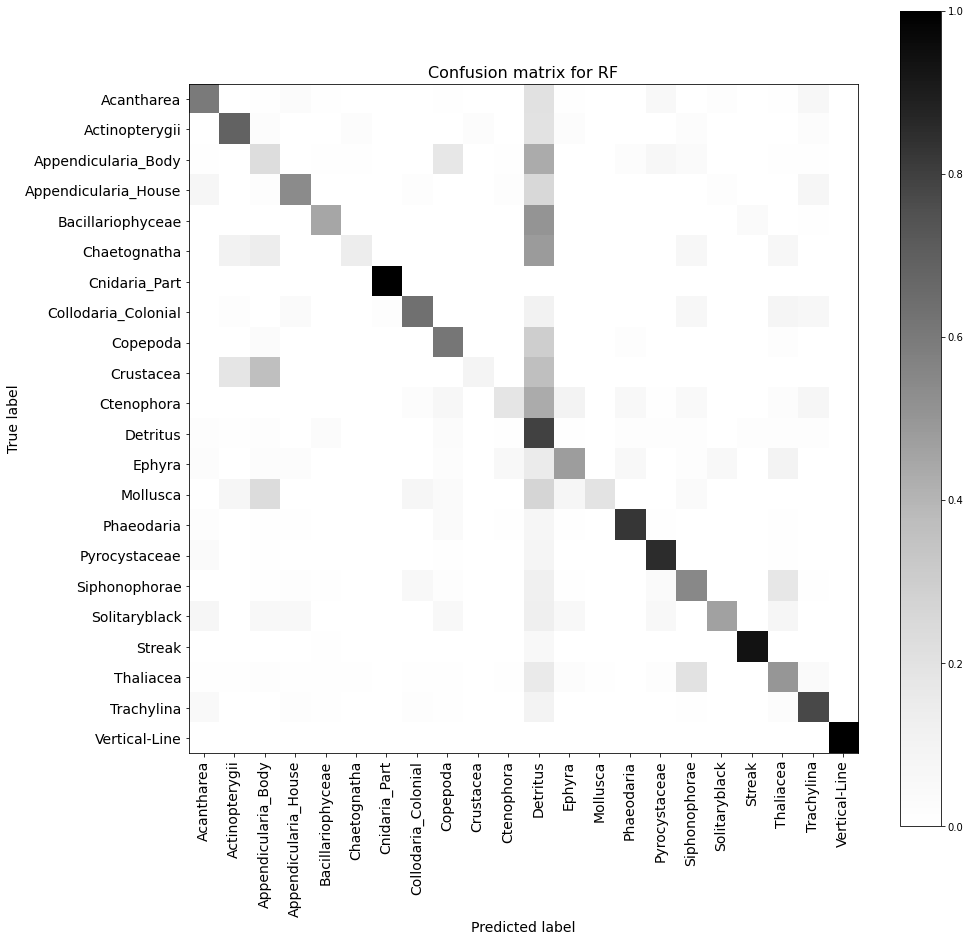

In [8]:
# Create confution matrix
cm = confusion_matrix(true_classes, predicted_classes, normalize='true')

# Plot it
plt.figure(figsize=(15,15))
plt.imshow(cm, cmap='Greys')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90, fontsize=14)
plt.yticks(tick_marks, classes, fontsize=14)
plt.ylabel('True label', fontsize=14)
plt.xlabel('Predicted label', fontsize=14)
plt.title("Confusion matrix for RF", fontsize=16)
plt.show()

### Classification report

Plot a classification report

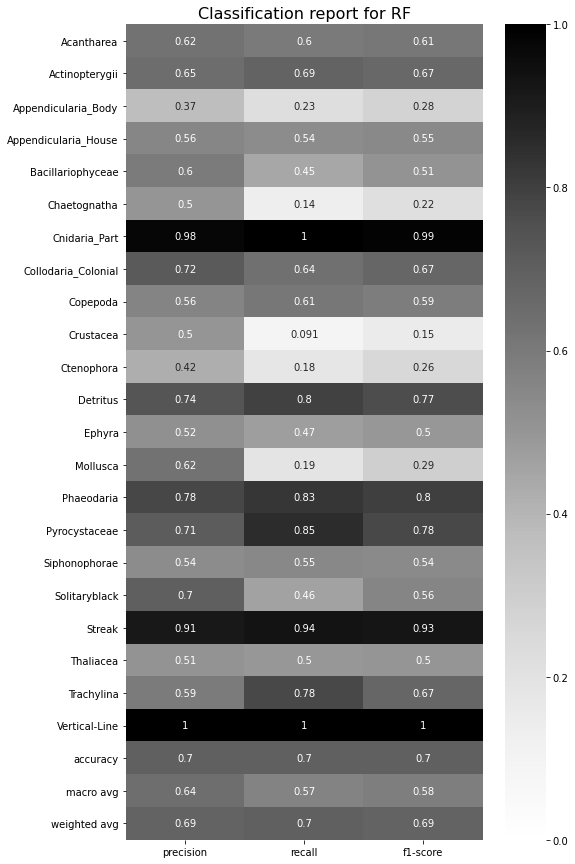

In [9]:
# Create classification report
report = classification_report(true_classes, predicted_classes, output_dict=True)

# List annotations for figure
annot = [str(x) for x in classes]
annot.extend(("accuracy", "macro avg", "weighted avg"))

# Convert report to dataframe
df_report = pd.DataFrame(report).transpose().drop('support', axis=1)

# Plot figure
plt.figure(figsize = (8,15))
sn.heatmap(df_report, annot=True, vmin=0, vmax=1.0,  yticklabels = annot, cmap="Greys")
plt.title("Classification report for RF", fontsize=16)
plt.show()